## Imports

In [28]:
#Python3.10
import pandas as pd 
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

from dateutil import relativedelta
from datetime import datetime
from shapely.geometry import Point

from dataretrieval import nwis, utils, codes

pd.options.mode.chained_assignment = None

## Classes

In [21]:
class StreamGauge:
    def __init__(self, id, name, mean_start_date, mean_end_date, post_start_date, post_end_date):
        self.id = id
        self.name = name
        # Start date for all-time mean daily flow data
        self.mean_start_date = mean_start_date
        self.mean_end_date = mean_end_date
        # Start date for post-impairment mean daily flow data
        self.post_start_date = post_start_date
        self.post_end_date = post_end_date 
        
    def get_id(self):
        """Return stream gauge USGS ID"""
        return self.id  
    
    def get_name(self):
        return self.name     
        
    def get_mean_date_range(self):
        """Return a time delta object between the start and end of the full record of streamflow data"""
        start_date = datetime.strptime(self.mean_start_date, "%Y-%m-%d")
        end_date = datetime.strptime(self.mean_end_date, "%Y-%m-%d")
        return relativedelta.relativedelta(end_date, start_date)
    
    def get_post_date_range(self):
        """Return a time delta object between the start and end of the post-impairment record of streamflow data"""
        start_date = datetime.strptime(self.post_start_date, "%Y-%m-%d")
        end_date = datetime.strptime(self.post_end_date, "%Y-%m-%d")
        return relativedelta.relativedelta(end_date, start_date)

## Inputs

In [22]:
# 11447650 -- Sacramento River Basin
# 11303500 -- San Joaquin-Tulare Basin
# SRB -- '1970-01-01' '2014-01-01'
# SJTB -- '1989-01-01' '2014-01-01'
# Water year -- Oct 1-Sept 30
        
SRB_Guage = StreamGauge('11447650', 'SACRAMENTO R A FREEPORT CA', '1948-10-01', '2014-09-30', '1970-10-01', '2014-09-30')
SJTB_Guage = StreamGauge('11303500', 'SAN JOAQUIN R NR VERNALIS CA', '1923-10-01', '2014-09-30', '1989-10-01', '2014-09-30')

# Change this to modify analysis values
curr_guage = SRB_Guage

QUANTILE = 0.90
STATE_CODE = 'OR'
HYDRO_YEAR = 'AS-OCT'
SERVICE = 'dv'
MIN_DATA_PERIOD = 30

# 00060 -- Discharge
# 00010 -- Temperature
PARAM_CODE = '00060'

# Site ID URI
SITES_URI = f'https://waterdata.usgs.gov/{STATE_CODE}/nwis/current?index_pmcode_STATION_NM=1&index_pmcode_DATETIME=2&index_pmcode_{PARAM_CODE}=3&group_key=NONE&format=sitefile_output&sitefile_output_format=rdb&column_name=site_no&column_name=station_nm&column_name=dec_lat_va&column_name=dec_long_va&column_name=sv_begin_date&column_name=sv_end_date&sort_key_2=site_no&html_table_group_key=NONE&rdb_compression=file&list_of_search_criteria=realtime_parameter_selection'

## Functions

In [41]:
# CONSTANTS
SEC_PER_DAY = 86400
CUBIC_FT_KM_FACTOR = 0.0000000000283168466

# FUNCTIONS
def calc_threshold(df: pd.DataFrame, value):
    """Returns a threshold above which flow is considered HMF given flow values and a threshold 0 < t < 1""" 
    df = pd.DataFrame(df['00060_Mean'])
    return df.quantile(q=value, axis=0).iloc[0]

def filter_hmf(df: pd.DataFrame, threshold):
    """Returns a dataframe with only flow values above a given threshold present"""
    return df[df['00060_Mean'] > threshold]

def convert_hmf(df: pd.DataFrame, threshold):
    """Converts flow values from ft^3/s to ft^3/day and returns only excess flow above a given threshold"""
    return (df['00060_Mean'] - threshold) * SEC_PER_DAY

def num_hmf_years(df: pd.DataFrame, offset):
    """Returns the integer number of HMF years, using an offset to indicate the start of the Hydrologic Year (i.e. 10 = October)"""
    df.loc[:, 'datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)
    
    #pd.options.mode.chained_assignment = None
    df.loc[:, 'offsetdate'] = (df.index - pd.offsets.YearBegin(month=offset))
    #pd.options.mode.chained_assignment = 'warn'
    
    return df['offsetdate'].dt.year.nunique()

def three_six_range(df: pd.DataFrame, three_start, three_end, six_start, six_end):
    """Returns two dataframes, one with a six month period, and one with a three month period, based on given start and end months for both"""
    df = df.reset_index()
    df.loc[:, 'datetime'] = pd.to_datetime(df['datetime'])    
    six_month_mask = (df['datetime'].dt.month >= six_start) | (df['datetime'].dt.month <= six_end)
    three_month_mask = (df['datetime'].dt.month >= three_start) | (df['datetime'].dt.month <= three_end)
    return df[six_month_mask], df[three_month_mask]

def calc_duration(df: pd.DataFrame):
    """Returns the total number of HMF days over the dataframes time period"""
    df.loc[:, 'datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)  
    df_results = df.resample(HYDRO_YEAR).agg({'00060_Mean': ['count']})
    df_results.columns = ['Count']
    return df_results['Count'].sum()
    
def convert_cubic_ft_hm(value):
    """Convert ft^3 to km^3"""
    return value * CUBIC_FT_KM_FACTOR
    

## Single Site Data<br>

In [50]:
# df2 holds all-time data, df is analyzed range
df = nwis.get_record(sites=curr_guage.id, service=SERVICE, parameterCD=PARAM_CODE, start=curr_guage.post_start_date, end=curr_guage.post_end_date)
df2 = nwis.get_record(sites=curr_guage.id, service=SERVICE, parameterCD=PARAM_CODE, start=curr_guage.mean_start_date, end=curr_guage.mean_end_date)
df = df.reset_index()
df2 = df2.reset_index()
#df2.to_csv('srb_full.csv')

print(f'Statistics for {curr_guage.get_name()}')

# 90th percentile calculation
threshold = calc_threshold(df2, QUANTILE)
print(f'90%: {threshold}')

# Create a dataframe with only days over HMF threshold 
hmf_series = filter_hmf(df, threshold)

# Find number of years with HMF 
hmf_years = num_hmf_years(hmf_series, 10)
print(f'HMF Years: {hmf_years}')

# Mask out months that don't fall within 3 and 6 month Winter range
df_six_month, df_three_month = three_six_range(hmf_series, 12, 2, 11, 4)

# Convert to daily average flow in cfps, and take only flow above the threshold
hmf_series = convert_hmf(hmf_series, threshold)
total_hmf_flow = hmf_series.sum()
#print(f'Total Volume of HMF: {total_hmf_flow}')

# Calculate 3 and 6 month HMF
df_six_month = convert_hmf(df_six_month, threshold)
six_month_hmf = df_six_month.sum()
df_three_month = convert_hmf(df_three_month, threshold)
three_month_hmf = df_three_month.sum()

# Inter-annual and Duration Calculation (across the full record)
hmf_series_full = filter_hmf(df2, threshold)
hmf_years_full = num_hmf_years(hmf_series_full, 10)

delta = curr_guage.get_mean_date_range()
inter_annual = (hmf_years_full / (delta.years + 1)) * 100

# Average Duration
hmf_series_dur = filter_hmf(df, threshold)
hmf_series_dur = pd.DataFrame(hmf_series_dur)
duration = calc_duration(hmf_series_dur)
avg_duration = duration / hmf_years

print(f'Average Duration: {avg_duration:.1f}')
print(f'Inter-annual Frequency: {inter_annual:.1f}%')
print(f'Total HMF in km^3/year: {((total_hmf_flow * CUBIC_FT_KM_FACTOR) / hmf_years):.1f}')
print(f'6 Month HMF in km^3/year: {((six_month_hmf * CUBIC_FT_KM_FACTOR) / hmf_years):.1f}')
print(f'3 Month HMF in km^3/year: {((three_month_hmf * CUBIC_FT_KM_FACTOR) / hmf_years):.1f}')


Statistics for SACRAMENTO R A FREEPORT CA
90%: 52350.0
HMF Years: 28
Average Duration: 53.8
Inter-annual Frequency: 71.2%
Total HMF in km^3/year: 2.4
6 Month HMF in km^3/year: 2.3
3 Month HMF in km^3/year: 1.4


## Multi-Site Data<br>

In [41]:
import requests
from io import StringIO

# Request page from USGS site, ignore all informational lines
response = requests.get(SITES_URI)
data = response.text
lines = data.splitlines()
lines = [line for line in lines if not line.startswith('#')]

# Create dataframe where site_no is a list of all sites in a state with 00060 data
tsd = "\n".join(lines)
df = pd.read_csv(StringIO(tsd), sep='\t')
df_state_sites = df.iloc[1:]

# Filter out sites with <30 years of data
df_state_sites['sv_begin_date'] = pd.to_datetime(df_state_sites['sv_begin_date'])
df_state_sites['sv_end_date'] = pd.to_datetime(df_state_sites['sv_end_date'])
df_state_sites['data_period'] = (df_state_sites['sv_end_date'] - df_state_sites['sv_begin_date']).dt.days / 365.25
df_state_sites = df_state_sites[df_state_sites['data_period'] >= MIN_DATA_PERIOD]

# Filter out sites outside of HU boundary
shapefile = gpd.read_file('ShapeFiles/OR/Shape/WBDHU12.shp')
df_state_sites['geometry'] = [Point(lon, lat) for lon, lat in zip(df_state_sites['dec_long_va'], df_state_sites['dec_lat_va'])]
gdf_data = gpd.GeoDataFrame(df_state_sites, crs=shapefile.crs)
df_state_sites = gpd.sjoin(gdf_data, shapefile, predicate='within')

print(f'Total Sites: {len(df_state_sites)} in the state of {STATE_CODE.upper()} in the given WB')

site_list = df_state_sites['site_no'].to_list()
print(site_list)
print(df_state_sites.columns.to_list())


Total Sites: 24 in the state of OR in the given WB
['14020000', '14020300', '14033500', '14034470', '14034500', '14038530', '14044000', '14046000', '14046500', '14048000', '14076500', '14087400', '14091500', '14092500', '14092750', '14093000', '14096850', '14097100', '14101500', '14103000', '14105700', '14113200', '14120000', '14123500']
['site_no', 'station_nm', 'dec_lat_va', 'dec_long_va', 'coord_acy_cd', 'dec_coord_datum_cd', 'sv_begin_date', 'sv_end_date', 'data_period', 'geometry', 'index_right', 'tnmid', 'metasource', 'sourcedata', 'sourceorig', 'sourcefeat', 'loaddate', 'referenceg', 'areaacres', 'areasqkm', 'states', 'huc12', 'name', 'hutype', 'humod', 'tohuc', 'noncontrib', 'noncontr_1', 'shape_Leng', 'shape_Area', 'ObjectID']


## Mapping<br>

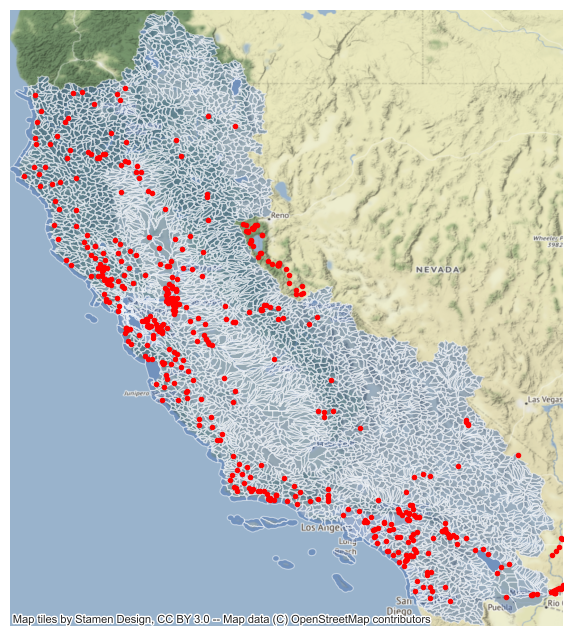

In [18]:
import contextily as cx

shape = gpd.read_file('ShapeFiles/CA/Shape/WBDHU12.shp')
#print(shape.crs)

#df = nwis.get_record(sites=SITE_NO, service='site')
#df2 = nwis.get_record(sites='11303500', service='site')
lat = df_state_sites['dec_lat_va'].tolist()
long = df_state_sites['dec_long_va'].tolist()

fig, ax = plt.subplots(figsize=(8, 8))
ax.margins(0)
shape.plot(ax=ax, alpha=0.50)

geometry = [Point(xy) for xy in zip(long, lat)]
geo_df = gpd.GeoDataFrame(geometry=geometry)

bx = geo_df.plot(ax=ax, markersize=40, color='red', marker='.', label='CA Watershed')
#bx.set_title("WBDHU8")
bx.margins(0, tight=True)
bx.set_axis_off()
cx.add_basemap(bx, crs=shape.crs)

## Data Visualization<br>

                                 Sum  Count
datetime                                   
1948-10-01 00:00:00+00:00    65750.0     13
1949-10-01 00:00:00+00:00   133500.0     14
1950-10-01 00:00:00+00:00  1289600.0     70
1951-10-01 00:00:00+00:00  2128950.0    159
1952-10-01 00:00:00+00:00   427200.0     30
...                              ...    ...
2008-10-01 00:00:00+00:00        0.0      0
2009-10-01 00:00:00+00:00    18600.0      6
2010-10-01 00:00:00+00:00   896550.0     49
2011-10-01 00:00:00+00:00        0.0      0
2012-10-01 00:00:00+00:00   106300.0     14

[65 rows x 2 columns]
Rows: 47
Correlation: 0.6181660900296607


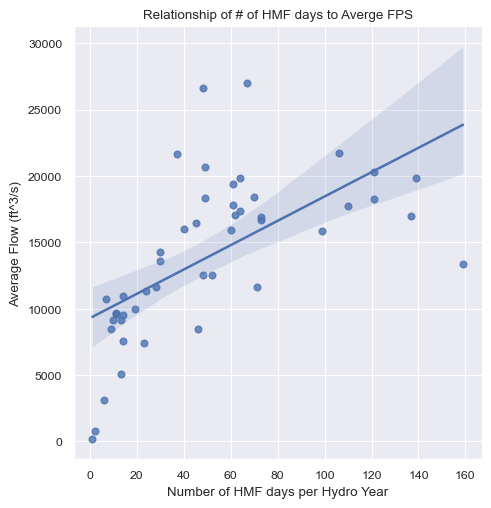

Rows: 39
Correlation w/No Outliers: 0.7340109778858693


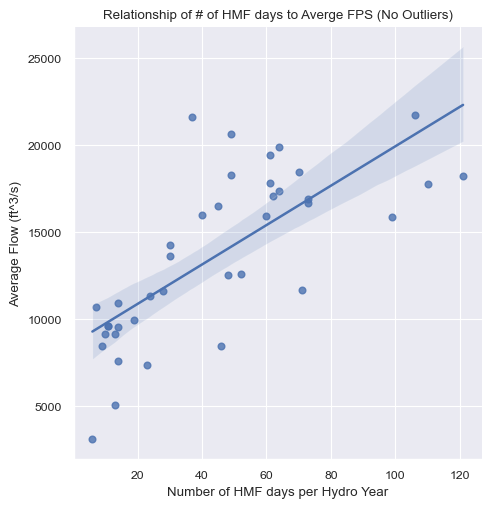

In [7]:
# Scatter plot looking at correlation between # of HMF days per hydrologic year, and average daily flow 
df = nwis.get_record(sites=curr_guage.id, service=SERVICE, parameterCD=PARAM_CODE, start=curr_guage.mean_start_date, end=curr_guage.mean_end_date)
hmf_series = df[df['00060_Mean'] > threshold]
hmf_series = hmf_series['00060_Mean'] - threshold
#hmf_series.to_csv('hmf_series.csv')
hmf_series = pd.DataFrame(hmf_series)
#hmf_series.set_index('datetime', inplace=True)

# Aggregate dataframe by total flow per day per hydro year, and # of HMF days per hydro year
df_results = hmf_series.resample(HYDRO_YEAR).agg({'00060_Mean': ['sum', 'count']})
df_results.columns = ['Sum', 'Count']
print(df_results)

# Remove all hydrologic years with no HMF and calculate average FPS/per day
df_results = df_results[df_results['Count'] != 0]
df_results['Average FPS'] = df_results['Sum'] / df_results['Count']
print(f'Rows: {len(df_results)}')

# Correlation
corr = df_results['Count'].corr(df_results['Average FPS'])
print(f'Correlation: {corr}')

# Data Plotting

#plt.figure(figsize=(6, 6))
sns.set(color_codes=True)
sns.set_context('paper')

sns.lmplot(data=df_results, x='Count', y='Average FPS')
plt.xlabel('Number of HMF days per Hydro Year')
plt.ylabel('Average Flow (ft^3/s)')
plt.title('Relationship of # of HMF days to Averge FPS')
plt.show()

# Remove outliers w/Z-score
z_scores = np.abs((df_results - df_results.mean()) / df_results.std())
#print(z_scores)

# Somewhat arbitrary threshold that removes just the most egregious outliers
threshold = 2
df_results_no = df_results[(z_scores <= threshold).all(axis=1)]

print(f'Rows: {len(df_results_no)}')
# Correlation no outliers
corr_no = df_results_no['Count'].corr(df_results_no['Average FPS'])
print(f'Correlation w/No Outliers: {corr_no}')

#plt.figure(figsize=(6, 6))
sns.lmplot(data=df_results_no, x='Count', y='Average FPS')
plt.xlabel('Number of HMF days per Hydro Year')
plt.ylabel('Average Flow (ft^3/s)')
plt.title('Relationship of # of HMF days to Averge FPS (No Outliers)')
plt.show()